# Tutorial for AutoSARIMA Forecasting Model

This notebook provides an advanced example on how to use the Auto Sarima forecasting model.

AutoSARIMA runs in 4 settings:
1. Full AutoSARIMA with approximation 
2. Full AutoSARIMA without approximation
3. Partial AutoSARIMA (Predefined AR, MA, Seasonal AR, Seasonal MA hyper-parameters)
4. Autosarima without enforcing stationarity and invertibility (this is the default setting) 

Example codes are provided for both cases below.

## Prepare dataset

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 414/414 [00:00<00:00, 845.77it/s]


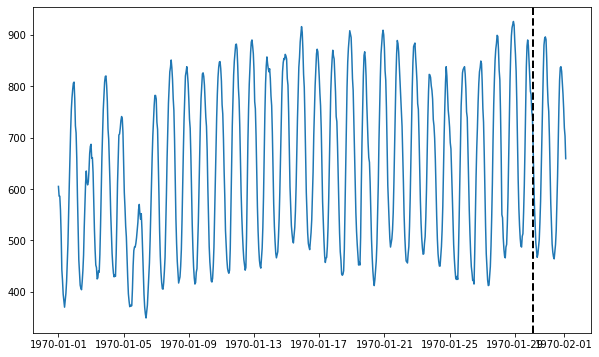

700 points in train split, 48 points in test split.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm
import logging

from merlion.utils.time_series import TimeSeries
from merlion.evaluate.forecast import ForecastMetric
from merlion.models.automl.autosarima import AutoSarima, AutoSarimaConfig
from merlion.models.forecast.sarima import Sarima

from ts_datasets.forecast import M4

logging.basicConfig(level=logging.INFO)

time_series, metadata = M4("Hourly")[0]
train_data = TimeSeries.from_pd(time_series[metadata.trainval])
test_data = TimeSeries.from_pd(time_series[~metadata.trainval])

# Visualize the time series and draw a dotted line to indicate the train/test split
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(time_series)
ax.axvline(metadata[metadata.trainval].index[-1], ls="--", lw="2", c="k")
plt.show()

# Print the length of training data and test data
print(f"{len(train_data)} points in train split, "
      f"{len(test_data)} points in test split.")

## Train a full AutoSarima model with approximation (suggested)

In [2]:
# Specify the configuration of AutoSarima with approximation
#
# p, q, P, Q refer to the AR, MA, seasonal AR, and seasonal MA params, so
# auto_pqPQ=True (default) means select them automatically
#
# d is the difference order, and D is the seasonal difference order, so
# auto_d=True (default) and auto_D=True (default) means select them automatically
#
# auto_seasonality=True (default) means to automatically select the seasonality
config1 = AutoSarimaConfig(auto_pqPQ=True, auto_d=True, auto_D=True, auto_seasonality=True,
                           approximation=True, maxiter=5)
model1  = AutoSarima(config1)

# Model training
train_pred, train_err = model1.train(
    train_data, train_config={"enforce_stationarity": True,"enforce_invertibility": True})

INFO:merlion.models.automl.seasonality:Automatically detect the periodicity is [24]
INFO:merlion.models.automl.autosarima:Seasonal difference order is 1
INFO:merlion.models.automl.autosarima:Difference order is 0
INFO:merlion.models.automl.autosarima:Fitting models using approximations(approx_iter is 1) to speed things up
INFO:merlion.models.automl.autosarima:Best model:  SARIMA(1,0,5)(0,1,2)[24] without constant


In [5]:
# Model forecasting
forecast1, stderr1 = model1.forecast(len(test_data))

# Model evaluation
smape1 = ForecastMetric.sMAPE.value(ground_truth=test_data, predict=forecast1)
print(f"Full AutoSarima with approximation sMAPE is {smape1:.4f}")

Full AutoSarima with approximation sMAPE is 3.4972


In [4]:
# Visualize the groud truth, actual forecast and confidence interval 
fig, ax = model1.plot_forecast(time_series=test_data, plot_forecast_uncertainty=True)
plt.show()

AttributeError: 'AutoSarimaConfig' object has no attribute 'invert_transform'

## Train a full AutoSarima model without approximation

In [6]:
# Specify the configuration of full AutoSarima without approximation
# Note that the default values of all the auto_* parameters are True
config2 = AutoSarimaConfig(approximation=False, maxiter=5)
model2  = AutoSarima(config2)

# Model training
train_pred, train_err = model2.train(
    train_data, train_config={"enforce_stationarity": True,"enforce_invertibility": True})

INFO:merlion.models.automl.seasonality:Automatically detect the periodicity is [24]
INFO:merlion.models.automl.autosarima:Seasonal difference order is 1
INFO:merlion.models.automl.autosarima:Difference order is 0
INFO:merlion.models.automl.autosarima:Best model:  SARIMA(5,0,1)(2,1,0)[24] without constant


In [7]:
# Model forecasting
forecast2, stderr2 = model2.forecast(len(test_data))

# Model evaluation
smape2 = ForecastMetric.sMAPE.value(ground_truth=test_data, predict=forecast2)
print(f"Full AutoSarima without approximation sMAPE is {smape2:.4f}")

Full AutoSarima without approximation sMAPE is 4.1451


In [8]:
# Visualize the groud truth, actual forecast and confidence interval 
fig, ax = model2.plot_forecast(time_series=test_data, plot_forecast_uncertainty=True)
plt.show()

AttributeError: 'AutoSarimaConfig' object has no attribute 'invert_transform'

## Train a partial autosarima model

Here, the user has pre-defined the AR, MA, Seasonal AR, and Seasonal MA hyper-parameters.

In [8]:
# Specify the configuration of partial AutoSarima 
# We explicitly specify values of p, q, P, Q in the order and seasonal order,
# and we set auto_pqPQ=False.
# Because auto_d=True, auto_D=True, and auto_seasonality=True by default, we
# can specify arbitrary values for them in the order and seasonal order (e.g. "auto")
config3 = AutoSarimaConfig(auto_pqPQ=False, order=(15, "auto", 5),
                           seasonal_order=(2, "auto", 1, "auto"), maxiter=5)
model3  = AutoSarima(config3)

# Model training
train_pred, train_err = model3.train(
    train_data, train_config={"enforce_stationarity": True,"enforce_invertibility": True})

INFO:merlion.models.automl.seasonality:Automatically detect the periodicity is 24
INFO:merlion.models.automl.autosarima:Seasonal difference order is 1
INFO:merlion.models.automl.autosarima:Difference order is 0


In [9]:
# Model forecasting
forecast3, stderr3 = model3.forecast(len(test_data))

# Model evaluation
smape3 = ForecastMetric.sMAPE.value(ground_truth=test_data, predict=forecast3)
print(f"Partial AutoSarima without approximation sMAPE is {smape3:.4f}")

Partial AutoSarima without approximation sMAPE is 3.5288


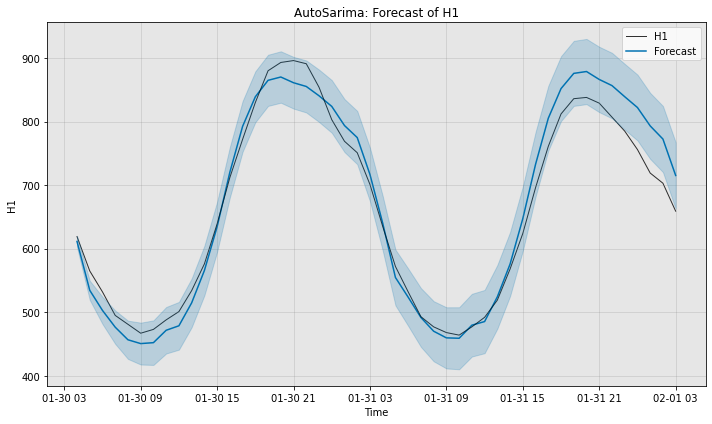

In [10]:
# Visualize the groud truth, actual forecast and confidence interval 
fig, ax = model3.plot_forecast(time_series=test_data, plot_forecast_uncertainty=True)
plt.show()

## Train without enforcing stationarity and invertibility (default)

In [11]:
# Specify the configuration of AutoSarima without enforcing stationarity and invertibility
config4 = AutoSarimaConfig(approximation=True, maxiter=5)
model4  = AutoSarima(config4)

# Model training
train_pred, train_err = model4.train(
    train_data, train_config={"enforce_stationarity": False,"enforce_invertibility": False})

INFO:merlion.models.automl.seasonality:Automatically detect the periodicity is 24
INFO:merlion.models.automl.autosarima:Seasonal difference order is 1
INFO:merlion.models.automl.autosarima:Difference order is 0
INFO:merlion.models.automl.autosarima:Fitting models using approximations(approx_iter is 1) to speed things up
INFO:merlion.models.automl.autosarima:Best model:  SARIMA(5,0,1)(2,1,0)[24] without constant


In [12]:
# Model forecasting
forecast4, stderr4 = model4.forecast(len(test_data))

# Model evaluation
smape4 = ForecastMetric.sMAPE.value(ground_truth=test_data, predict=forecast4)
print(f"AutoSarima without enforcing stationarity and invertibility sMAPE is {smape4:.4f}")

AutoSarima without enforcing stationarity and invertibility sMAPE is 4.2063


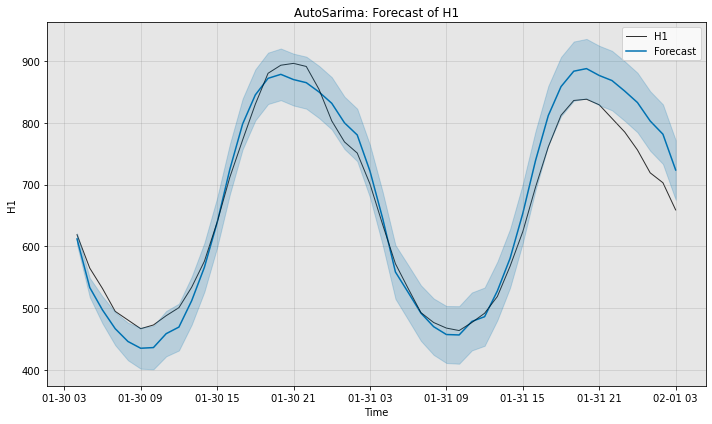

In [13]:
# Visualize the groud truth, actual forecast and confidence interval 
fig, ax = model4.plot_forecast(time_series=test_data, plot_forecast_uncertainty=True)
plt.show()